## **Dataset Generation**

This notebook describes the construction of a multivariate time series dataset composed of macroeconomic and financial indicators, together with binary labels identifying periods of economic recession or normal conditions in the United States, covering the period from 1969 to 2025.

The dataset is built through a systematic analysis of individual time series, followed by preprocessing and merging steps to ensure temporal consistency and suitability for downstream modeling tasks.

#### **Data Generation Description**

1. **Labels Time Series Analysis**

The recession label time series was not analyzed in depth within this notebook. It was converted to a time-indexed format to ensure proper temporal alignment and its sampling frequency was verified. A detailed analysis of label distribution and class imbalance is performed separately in the [Class Imbalance Notebook](class_imbalance.ipynb).



2. **Individual Time Series Analysis**

Each macroeconomic and financial indicator was analyzed independently following a common preprocessing pipeline:

- Inspection of dataset metadata and summary statistics

- Conversion of the date column to a time series index

- Verification of the original sampling frequency

- Aggregation to quarterly frequency (using mean values) when necessary, to match the label time scale

- Stationarity assessment using the Augmented Dickey–Fuller (ADF) test

    - When non-stationarity was detected, differencing was applied iteratively until stationarity was achieved

- Computation of correlation measures using the stationary versions of the series

This procedure ensures that all variables are comparable and suitable for multivariate temporal modeling.

3. **Dataset Merging**

All preprocessed time series (in their stationary form) were merged with the recession labels to create a unified multivariate dataset. Due to differing start dates across indicators, the merged dataset contains missing values, primarily at the beginning of the time span.

Two dataset versions were generated:

- A complete version retaining missing values, handled in the [Missing Data Notebook](missing_data.ipynb)

- A reduced version obtained by dropping missing observations (data_merged.csv)

This dual representation enables a controlled analysis of the impact of missing data handling on model performance.

All auxiliary preprocessing functions used in this notebook are available in [Data Generation Utils](../src/data/data_generation_utils.py).

In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.data.data_generation_utils import *

### **Labels**

This dataset file contains the classification of several time periods (quarters) as Recession or Normal Period. It includes data from 01-10-1969 up to 01-04-2024, from the United States. 

This data will serve as the labels for the final dataset obtained in the end of this notebook.

Data source: https://fred.stlouisfed.org/series/JHDUSRGDPBR

In [4]:
labels_df = pd.read_csv('../datasets/labels.csv')
labels_df.tail()

,observation_date,JHDUSRGDPBR
226,2024-04-01,0
227,2024-07-01,0
228,2024-10-01,0
229,2025-01-01,0
230,2025-04-01,0


In [3]:
labels_df = labels_df.rename(columns={'JHDUSRGDPBR': 'label'})
print("Label possible values", labels_df['label'].unique())

Label possible values [0 1]


In [4]:
labels_df = convert_date_to_datetime(labels_df, 'observation_date')
labels_df.head()

,label
date,
1967-10-01,0
1968-01-01,0
1968-04-01,0
1968-07-01,0
1968-10-01,0


To further merge our data, we assessed the labels time frequency. `target_frequency` will be used to aggregate other datasets.

In [5]:
_, target_frequency = verify_ts_time_frequency(labels_df, 'Labels')
print("Label time frequency: ", target_frequency)

Label time frequency:  QS-OCT


### **Macroeconomic Indicators Data**

In [6]:
macroeconomic_indicators = ['GDP', 'UNRATE', 'CPIAUCSL', 'INDPRO']

#### 1. **Gross Domestic Product**

Gross Domestic Product is the total monetary value of all final goods and services produced within a country's borders over a specific time. 

Data availability: 01/01/1965 –  01/072025

Data source: https://fred.stlouisfed.org/series/GDP 

In [7]:
gdp_df = pd.read_csv('../datasets/GDP.csv')
gdp_df.head()

,observation_date,GDP
0,1965-01-01,717.790
1,1965-04-01,730.191
2,1965-07-01,749.323
3,1965-10-01,771.857
4,1966-01-01,795.734


In [8]:
df_info(gdp_df)

,dtype,missing,n_unique,mean,std,min,max
observation_date,object,0,243,NaN,NaN,NaN,NaN
GDP,float64,0,243,9818.398753,8018.775733,717.79,31095.089


In [9]:
gdp_ts = convert_date_to_datetime(gdp_df, 'observation_date')
# print("Date Column type: ", (gdp_ts['date'].dtype))
gdp_ts.head()

,GDP
date,
1965-01-01,717.790
1965-04-01,730.191
1965-07-01,749.323
1965-10-01,771.857
1966-01-01,795.734


In [10]:
name, frequency = verify_ts_time_frequency(gdp_ts, 'GDP')
print(name,": ",frequency)

GDP :  QS-OCT


In [11]:
gdp_ts = aggregate_trimesters(ts_df=gdp_ts, ts_df_name='GDP', time_series_freq=frequency, target_frequency='QS-OCT', aggregate_method='mean')

GDP Time Series is already in the target frequency (QS-OCT)


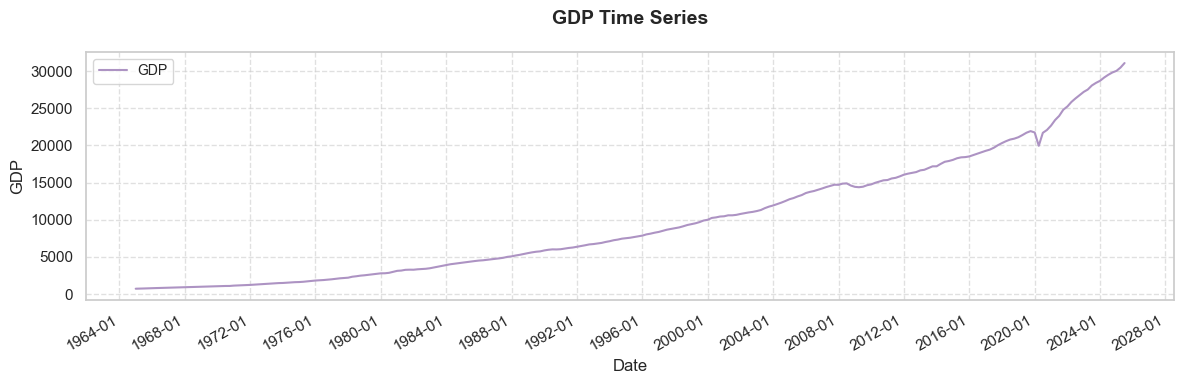

In [12]:
plot_time_series(gdp_ts, 'GDP')

In [13]:
results_gdp = run_adf_test(gdp_ts, 'GDP')
results_gdp

(  Feature  ADF Statistic  p-value  Stationary
 0     GDP       7.509768      1.0       False,
 False)

In [14]:
gdp_ts_diff, diff_col_name = difference_ts(gdp_ts, column_name='GDP')
gdp_ts_diff.head()

,GDP,GDP_diff
date,,
1965-01-01,717.790,NaN
1965-04-01,730.191,12.401
1965-07-01,749.323,19.132
1965-10-01,771.857,22.534
1966-01-01,795.734,23.877


In [15]:
results_gdp = run_adf_test(gdp_ts_diff, 'GDP_diff')
results_gdp

(    Feature  ADF Statistic   p-value  Stationary
 0  GDP_diff      -3.507812  0.007789        True,
 True)

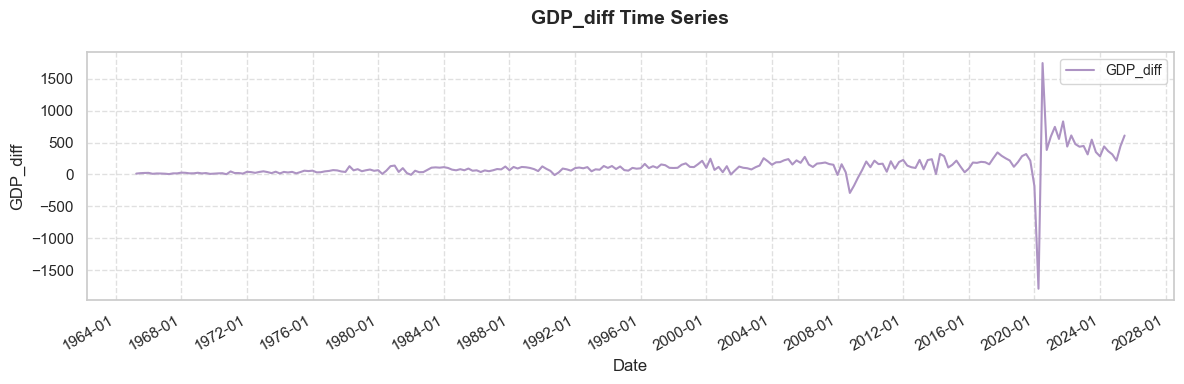

In [16]:
plot_time_series(gdp_ts_diff, 'GDP_diff')

In [17]:
final_gdp = gdp_ts_diff
final_gdp.head()

,GDP,GDP_diff
date,,
1965-01-01,717.790,NaN
1965-04-01,730.191,12.401
1965-07-01,749.323,19.132
1965-10-01,771.857,22.534
1966-01-01,795.734,23.877


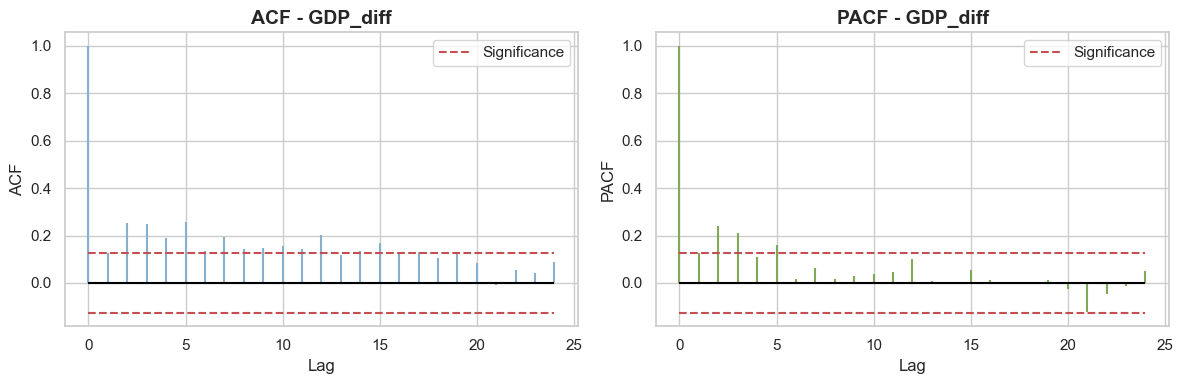

In [18]:
plot_correlations(final_gdp, 'GDP_diff', lags=24)

#### 2. **Unemployment Rate**

The unemployment rate measures the percentage of the total labor force that is jobless but actively seeking work. 

Data availability: 01/01/1965 –  01/112025

Data source: https://fred.stlouisfed.org/series/UNRATE

In [19]:
unrate_df = pd.read_csv('../datasets/UNRATE.csv')
unrate_df.head()

,observation_date,UNRATE
0,1965-01-01,4.9
1,1965-02-01,5.1
2,1965-03-01,4.7
3,1965-04-01,4.8
4,1965-05-01,4.6


Dataset Information:
                     dtype  missing  n_unique      mean       std  min   max
observation_date   object        0       731       NaN       NaN  NaN   NaN
UNRATE            float64        1        74  5.878904  1.756069  3.4  14.8
Time Series Dataset:
             UNRATE
date              
1965-01-01     4.9
1965-02-01     5.1
1965-03-01     4.7
1965-04-01     4.8
1965-05-01     4.6
UNRATE Time Series frequency changed from MS to QS-OCT
Aggregated dataset:
               UNRATE
date                
1965-01-01  4.900000
1965-04-01  4.666667
1965-07-01  4.366667
1965-10-01  4.100000
1966-01-01  3.866667



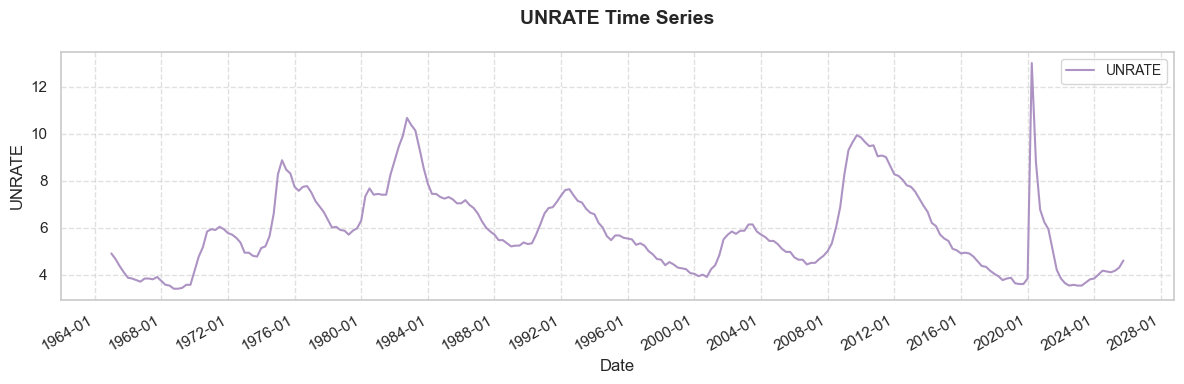

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0  UNRATE      -3.322044  0.013921        True


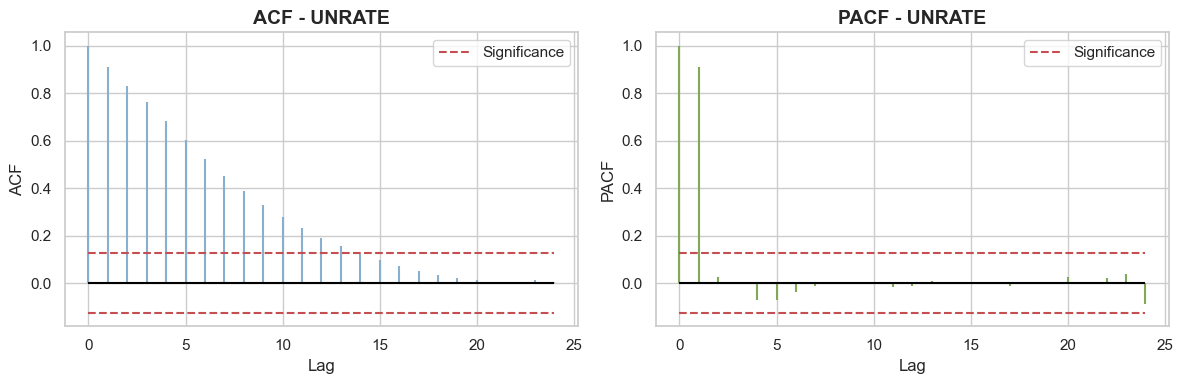

In [20]:
final_unrate = time_series_analysis_main(unrate_df, date_column_name='observation_date', column_name='UNRATE', lags=24)

#### 3. **Consumer Price Index for All Urban Consumers**

Consumer Price Index for All Urban Consumers measures the average change over time in the prices consumers pay for a fixed "basket" of everyday goods and services, serving as the key indicator of inflation and cost of living changes for urban households.

Data availability: 01/01/1965 –  01/112025

Data source: https://fred.stlouisfed.org/series/CPIAUCSL

In [21]:
cpi_df = pd.read_csv('../datasets/CPIAUCSL.csv')
cpi_df.head()

,observation_date,CPIAUCSL
0,1965-01-01,31.28
1,1965-02-01,31.28
2,1965-03-01,31.31
3,1965-04-01,31.38
4,1965-05-01,31.48


In [22]:
cpi_df = cpi_df.rename(columns={'CPIAUCSL': 'CPI'})

Dataset Information:
                     dtype  missing  n_unique        mean        std    min  \
observation_date   object        0       731         NaN        NaN    NaN   
CPI               float64        1       699  152.129889  81.910459  31.28   

                      max  
observation_date      NaN  
CPI               325.031  
Time Series Dataset:
               CPI
date             
1965-01-01  31.28
1965-02-01  31.28
1965-03-01  31.31
1965-04-01  31.38
1965-05-01  31.48
CPI Time Series frequency changed from MS to QS-OCT
Aggregated dataset:
                   CPI
date                 
1965-01-01  31.290000
1965-04-01  31.490000
1965-07-01  31.583333
1965-10-01  31.750000
1966-01-01  32.046667



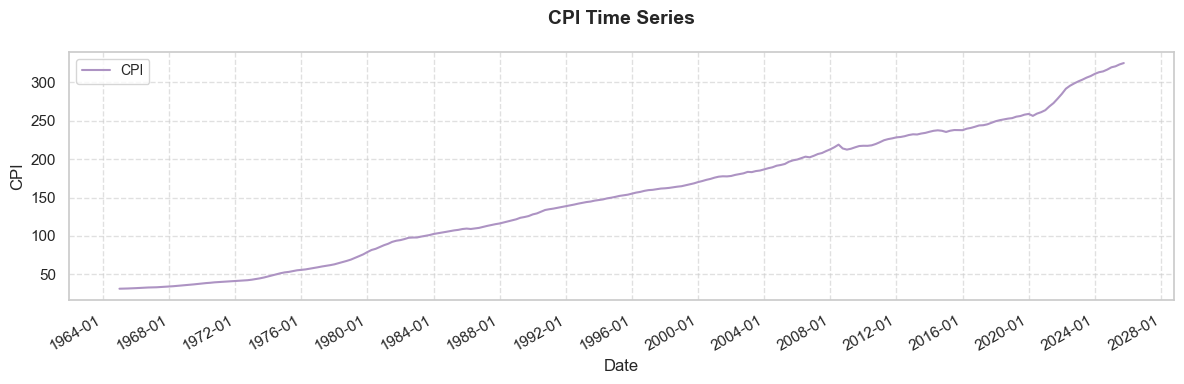

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0     CPI       1.546793  0.997689       False
Differenced Time Series df:
                    CPI  CPI_diff
date                            
1965-01-01   31.290000       NaN
1965-04-01   31.490000  0.200000
1965-07-01   31.583333  0.093333
1965-10-01   31.750000  0.166667
1966-01-01   32.046667  0.296667
...                ...       ...
2024-10-01  316.538667  2.356000
2025-01-01  319.492000  2.953333
2025-04-01  320.800333  1.308333
2025-07-01  323.288000  2.487667
2025-10-01  325.031000  1.743000

[244 rows x 2 columns]
ADF test results:
     Feature  ADF Statistic   p-value  Stationary
0  CPI_diff      -3.902242  0.002018        True


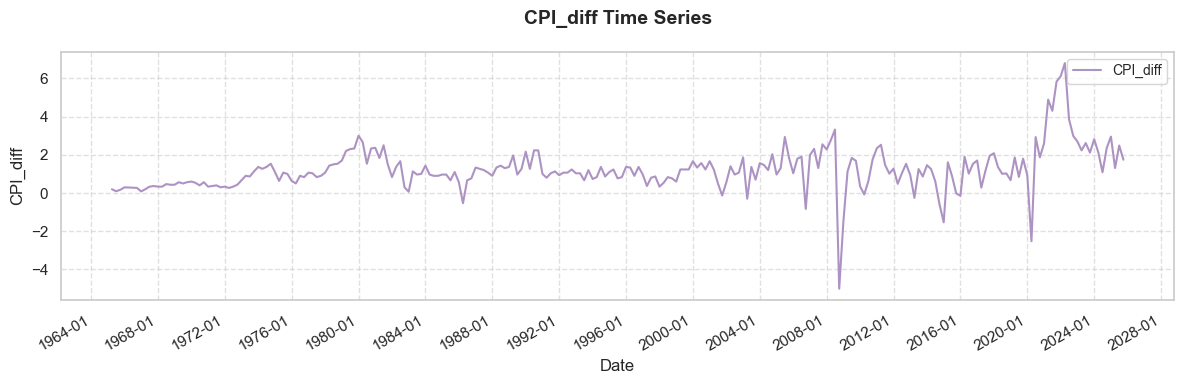

The Time Series is now stationary, after 1 differencing


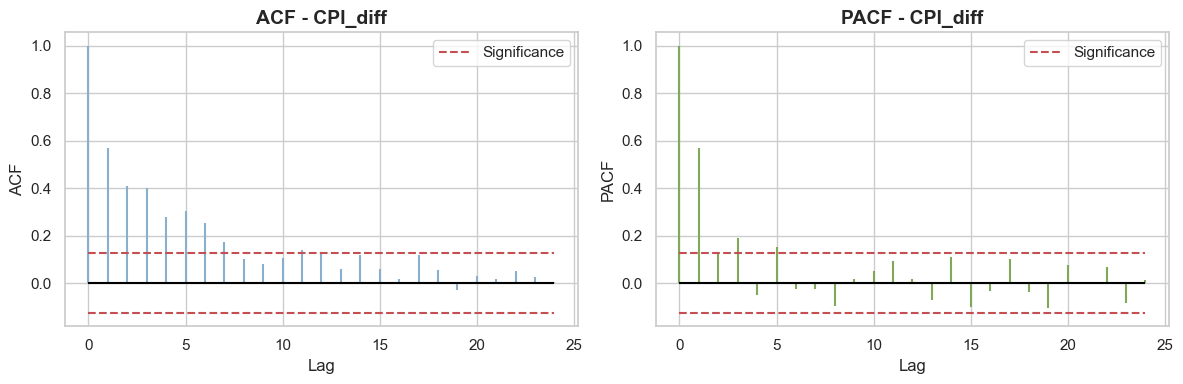

,CPI,CPI_diff
date,,
1965-01-01,31.290000,NaN
1965-04-01,31.490000,0.200000
1965-07-01,31.583333,0.093333
1965-10-01,31.750000,0.166667
1966-01-01,32.046667,0.296667


In [23]:
final_cpi = time_series_analysis_main(cpi_df, date_column_name='observation_date', column_name='CPI', lags=24)
final_cpi.head()

#### 4. **Industrial Production Total Index**

The Industrial Production Total Index measures monthly changes in the real output of the industrial sector, specifically manufacturing, mining, and electric/gas utilities.

Data availability: 01/01/1965 –  01/112025

Data source: https://fred.stlouisfed.org/series/INDPRO

In [24]:
indpro_df = pd.read_csv('../datasets/INDPRO.csv')
indpro_df.head()

,observation_date,INDPRO
0,1965-01-01,30.3204
1,1965-02-01,30.5089
2,1965-03-01,30.9128
3,1965-04-01,31.0474
4,1965-05-01,31.2898


Dataset Information:
                     dtype  missing  n_unique      mean        std      min  \
observation_date   object        0       731       NaN        NaN      NaN   
INDPRO            float64        0       730  72.36045  24.290359  30.3204   

                       max  
observation_date       NaN  
INDPRO            104.1004  
Time Series Dataset:
              INDPRO
date               
1965-01-01  30.3204
1965-02-01  30.5089
1965-03-01  30.9128
1965-04-01  31.0474
1965-05-01  31.2898
INDPRO Time Series frequency changed from MS to QS-OCT
Aggregated dataset:
                INDPRO
date                 
1965-01-01  30.580700
1965-04-01  31.289767
1965-07-01  31.945033
1965-10-01  32.591267
1966-01-01  33.524800



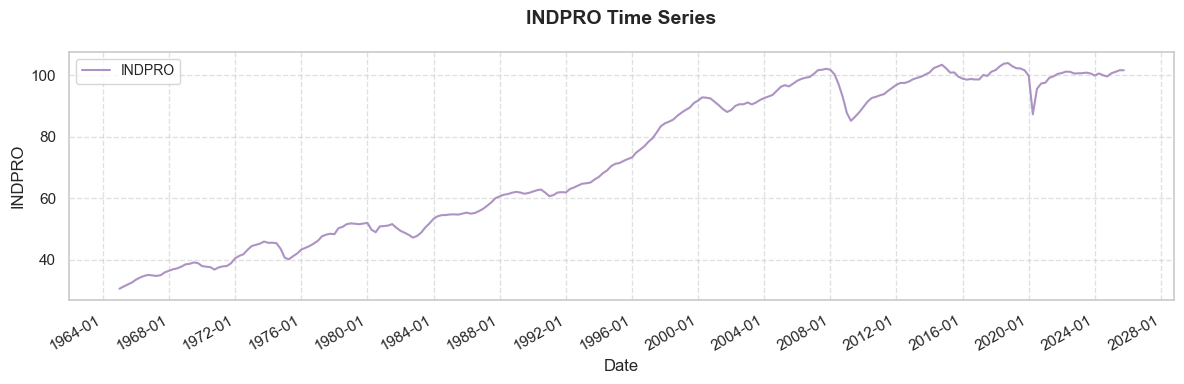

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0  INDPRO      -1.225042  0.662732       False
Differenced Time Series df:
                 INDPRO  INDPRO_diff
date                               
1965-01-01   30.580700          NaN
1965-04-01   31.289767     0.709067
1965-07-01   31.945033     0.655267
1965-10-01   32.591267     0.646233
1966-01-01   33.524800     0.933533
...                ...          ...
2024-10-01   99.696433    -0.375233
2025-01-01  100.734800     1.038367
2025-04-01  101.190633     0.455833
2025-07-01  101.716200     0.525567
2025-10-01  101.704750    -0.011450

[244 rows x 2 columns]
ADF test results:
        Feature  ADF Statistic       p-value  Stationary
0  INDPRO_diff     -13.234862  9.423356e-25        True


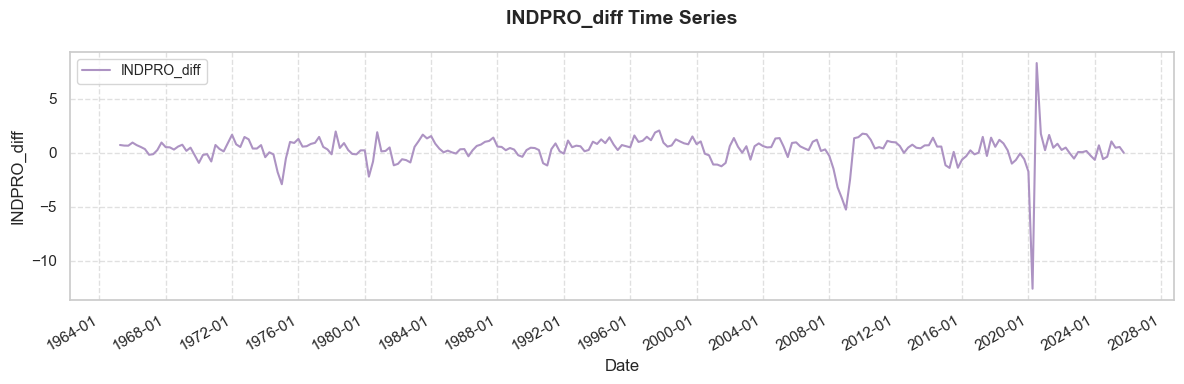

The Time Series is now stationary, after 1 differencing


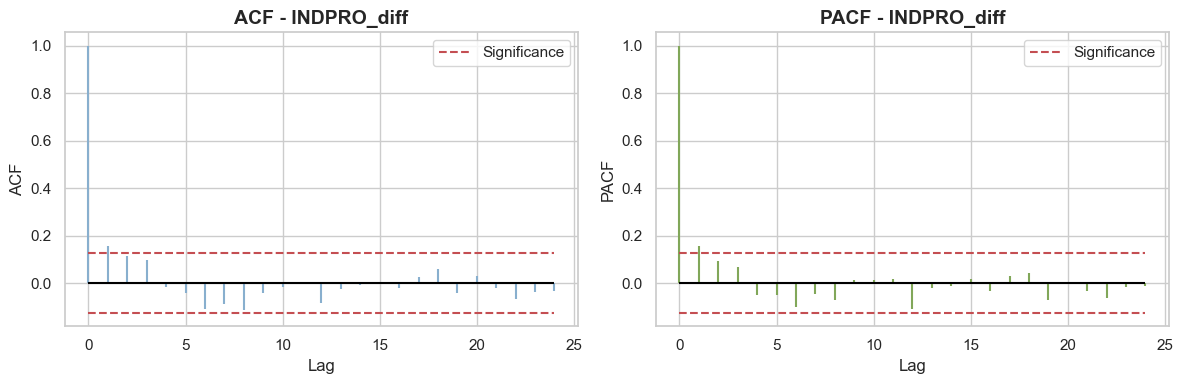

,INDPRO,INDPRO_diff
date,,
1965-01-01,30.580700,NaN
1965-04-01,31.289767,0.709067
1965-07-01,31.945033,0.655267
1965-10-01,32.591267,0.646233
1966-01-01,33.524800,0.933533


In [25]:
final_indpro = time_series_analysis_main(indpro_df, date_column_name='observation_date', column_name='INDPRO', lags=24)
final_indpro.head()

### **Financial Indicators Data**

In [26]:
financial_indicators= ['DFF', 'DGS10', 'DGS2', 'T10Y2Y', 'VIXCLS', 'DTB3']

#### 1. **Federal Funds Effective Rate** (DFF)

Federal Funds Effective Rate is the volume-weighted average interest rate at which U.S. banks lend their excess reserves to each other overnight.

Data availability: 01/01/1965 – 26/09/2025

Data source: https://fred.stlouisfed.org/series/DFF

In [27]:
dff_df = pd.read_csv('../datasets/DFF.csv')
dff_df.head()

,observation_date,DFF
0,1965-01-01,4.0
1,1965-01-02,4.0
2,1965-01-03,4.0
3,1965-01-04,4.0
4,1965-01-05,4.0


Dataset Information:
                     dtype  missing  n_unique      mean       std   min    max
observation_date   object        0     22275       NaN       NaN   NaN    NaN
DFF               float64        0      1557  4.945183  3.730818  0.04  22.36
Time Series Dataset:
             DFF
date           
1965-01-01  4.0
1965-01-02  4.0
1965-01-03  4.0
1965-01-04  4.0
1965-01-05  4.0
DFF Time Series frequency changed from D to QS-OCT
Aggregated dataset:
                  DFF
date                
1965-01-01  3.977222
1965-04-01  4.079451
1965-07-01  4.077500
1965-10-01  4.170761
1966-01-01  4.559000



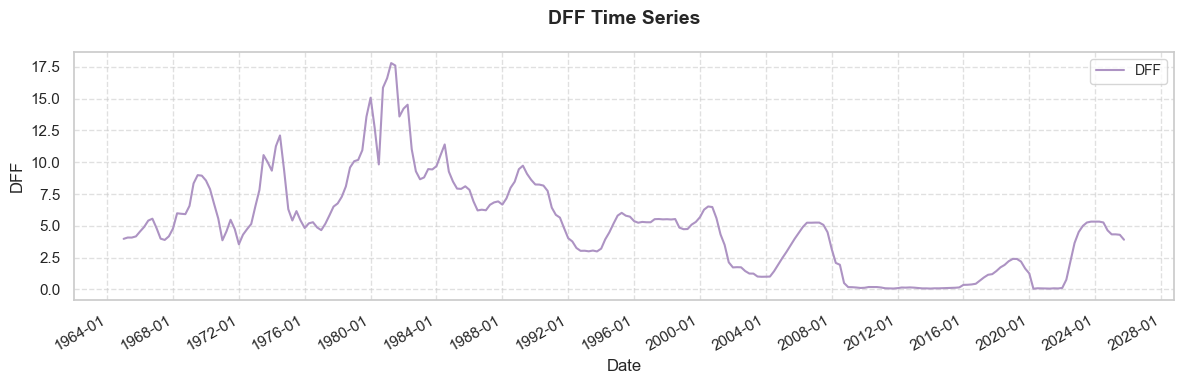

ADF test results:
   Feature  ADF Statistic  p-value  Stationary
0     DFF      -2.024744  0.27583       False
Differenced Time Series df:
                  DFF  DFF_diff
date                          
1965-01-01  3.977222       NaN
1965-04-01  4.079451  0.102228
1965-07-01  4.077500 -0.001951
1965-10-01  4.170761  0.093261
1966-01-01  4.559000  0.388239
...              ...       ...
2024-10-01  4.647935 -0.616848
2025-01-01  4.330000 -0.317935
2025-04-01  4.330000  0.000000
2025-07-01  4.295652 -0.034348
2025-10-01  3.909885 -0.385767

[244 rows x 2 columns]
ADF test results:
     Feature  ADF Statistic       p-value  Stationary
0  DFF_diff      -6.834843  1.853803e-09        True


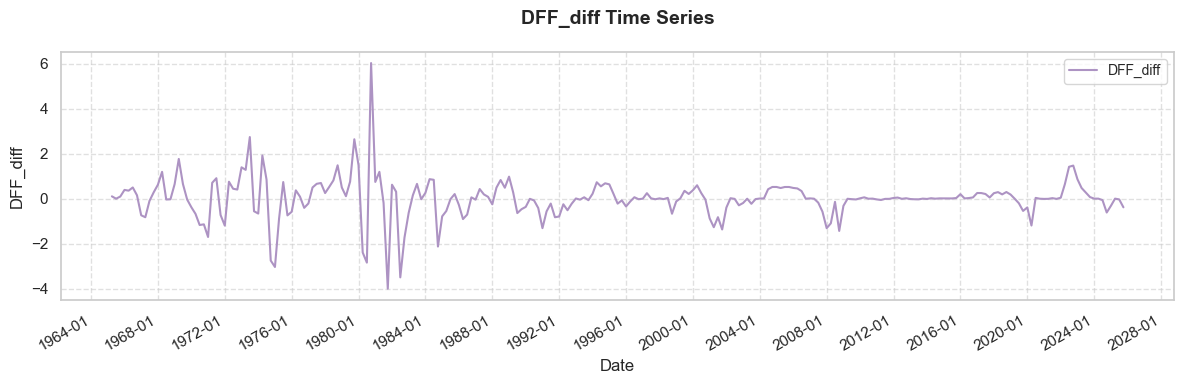

The Time Series is now stationary, after 1 differencing


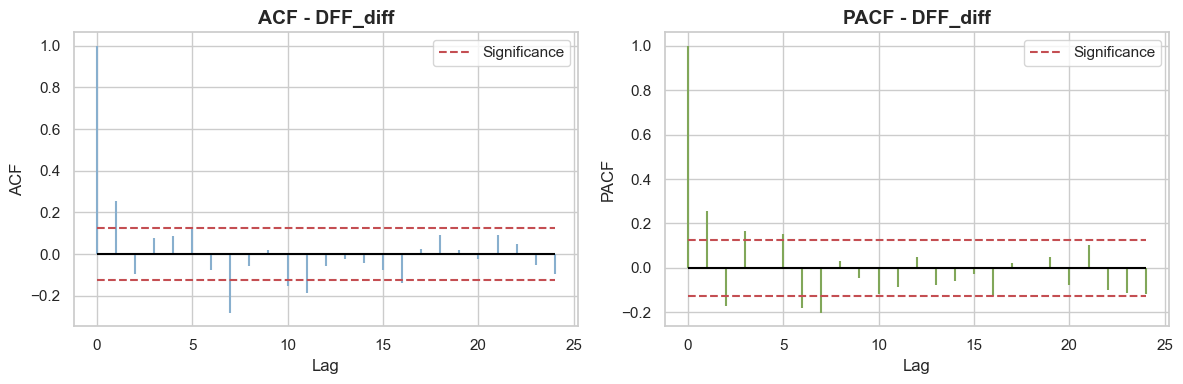

,DFF,DFF_diff
date,,
1965-01-01,3.977222,NaN
1965-04-01,4.079451,0.102228
1965-07-01,4.077500,-0.001951
1965-10-01,4.170761,0.093261
1966-01-01,4.559000,0.388239


In [28]:
final_dff = time_series_analysis_main(df=dff_df, date_column_name='observation_date', column_name='DFF',lags=24, aggregate_method='mean') 
final_dff.head()

#### 2. **Market Yield in U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis** (DGS10)

This refers to an interpolated, risk-free interest rate representing what a 10-year government loan would pay today, derived from the average of actively traded Treasury notes.

Data availability: 04/01/1965 – 26/09/2025

Data source: https://fred.stlouisfed.org/series/DGS10

In [29]:
dgs10_df = pd.read_csv('../datasets/DGS10.csv')
dgs10_df.head()

,observation_date,DGS10
0,1965-01-04,4.2
1,1965-01-05,4.2
2,1965-01-06,4.2
3,1965-01-07,4.2
4,1965-01-08,4.2


Dataset Information:
                     dtype  missing  n_unique      mean       std   min    max
observation_date   object        0     15910       NaN       NaN   NaN    NaN
DGS10             float64      677      1394  5.907807  2.985558  0.52  15.84
Time Series Dataset:
             DGS10
date             
1965-01-04    4.2
1965-01-05    4.2
1965-01-06    4.2
1965-01-07    4.2
1965-01-08    4.2
DGS10 Time Series frequency changed from B to QS-OCT
Aggregated dataset:
                DGS10
date                
1965-01-01  4.203770
1965-04-01  4.209524
1965-07-01  4.249219
1965-10-01  4.476393
1966-01-01  4.773968



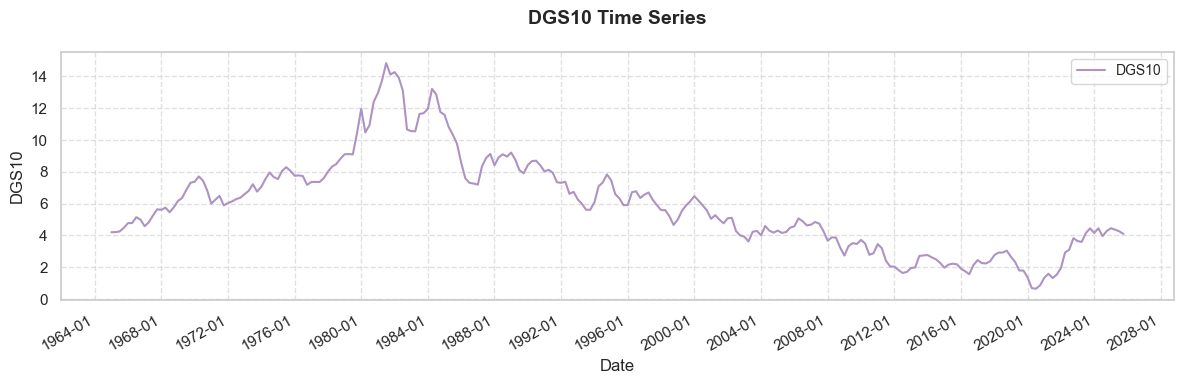

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0   DGS10      -1.142363  0.697886       False
Differenced Time Series df:
                DGS10  DGS10_diff
date                            
1965-01-01  4.203770         NaN
1965-04-01  4.209524    0.005753
1965-07-01  4.249219    0.039695
1965-10-01  4.476393    0.227175
1966-01-01  4.773968    0.297575
...              ...         ...
2024-10-01  4.275484    0.320796
2025-01-01  4.453607    0.178123
2025-04-01  4.361774   -0.091832
2025-07-01  4.261094   -0.100680
2025-10-01  4.097627   -0.163467

[244 rows x 2 columns]
ADF test results:
       Feature  ADF Statistic       p-value  Stationary
0  DGS10_diff      -6.942627  1.015890e-09        True


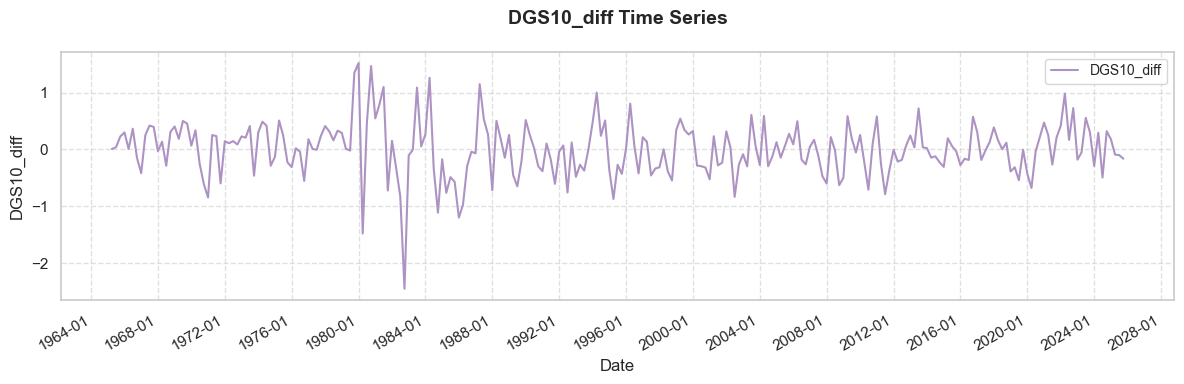

The Time Series is now stationary, after 1 differencing


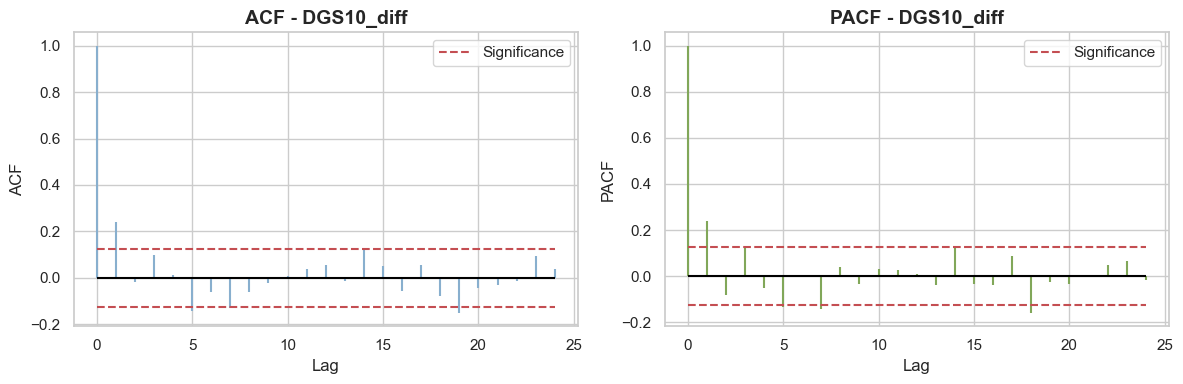

,DGS10,DGS10_diff
date,,
1965-01-01,4.203770,NaN
1965-04-01,4.209524,0.005753
1965-07-01,4.249219,0.039695
1965-10-01,4.476393,0.227175
1966-01-01,4.773968,0.297575


In [30]:
final_dgs10 = time_series_analysis_main(df=dgs10_df, date_column_name='observation_date', column_name='DGS10', lags=24, aggregate_method='mean')
final_dgs10.head()

#### 3. **Market Yield in U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis** (DGS2)

This refers to an interpolated, risk-free interest rate representing what a 2-year government loan would pay today, derived from the average of actively traded Treasury notes.

Data availability: 01/06/1976 – 26/09/2025

Data source: https://fred.stlouisfed.org/series/DGS2

In [31]:
dgs2_df = pd.read_csv('../datasets/DGS2.csv')
dgs2_df.head()

,observation_date,DGS2
0,1976-06-01,7.26
1,1976-06-02,7.23
2,1976-06-03,7.22
3,1976-06-04,7.12
4,1976-06-07,7.09


Dataset Information:
                     dtype  missing  n_unique     mean       std   min    max
observation_date   object        0     12934      NaN       NaN   NaN    NaN
DGS2              float64      545      1491  4.96746  3.676636  0.09  16.95
Time Series Dataset:
             DGS2
date            
1976-06-01  7.26
1976-06-02  7.23
1976-06-03  7.22
1976-06-04  7.12
1976-06-07  7.09
DGS2 Time Series frequency changed from B to QS-OCT
Aggregated dataset:
                 DGS2
date                
1976-04-01  7.060000
1976-07-01  6.632500
1976-10-01  5.710820
1977-01-01  6.024762
1977-04-01  6.117778



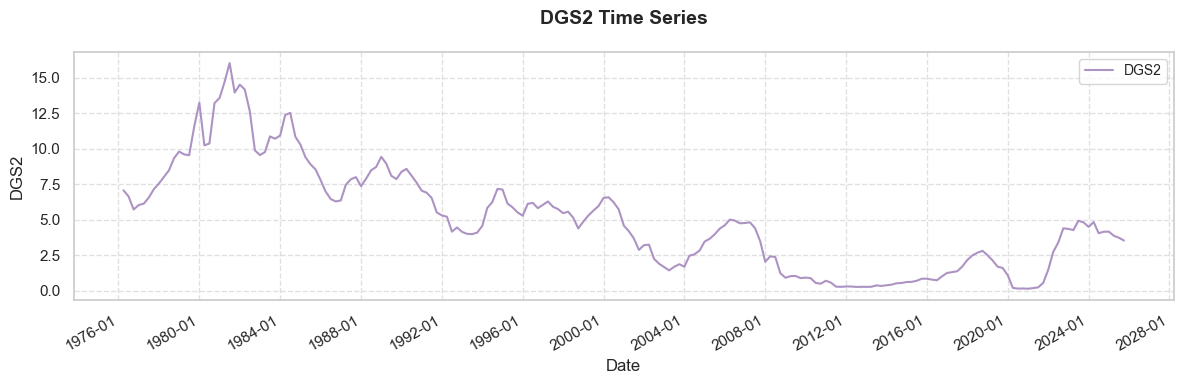

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0    DGS2      -1.365624  0.598641       False
Differenced Time Series df:
                 DGS2  DGS2_diff
date                           
1976-04-01  7.060000        NaN
1976-07-01  6.632500  -0.427500
1976-10-01  5.710820  -0.921680
1977-01-01  6.024762   0.313942
1977-04-01  6.117778   0.093016
...              ...        ...
2024-10-01  4.145484   0.104859
2025-01-01  4.148689   0.003205
2025-04-01  3.861774  -0.286914
2025-07-01  3.720781  -0.140993
2025-10-01  3.525763  -0.195019

[199 rows x 2 columns]
ADF test results:
      Feature  ADF Statistic       p-value  Stationary
0  DGS2_diff      -6.292821  3.564747e-08        True


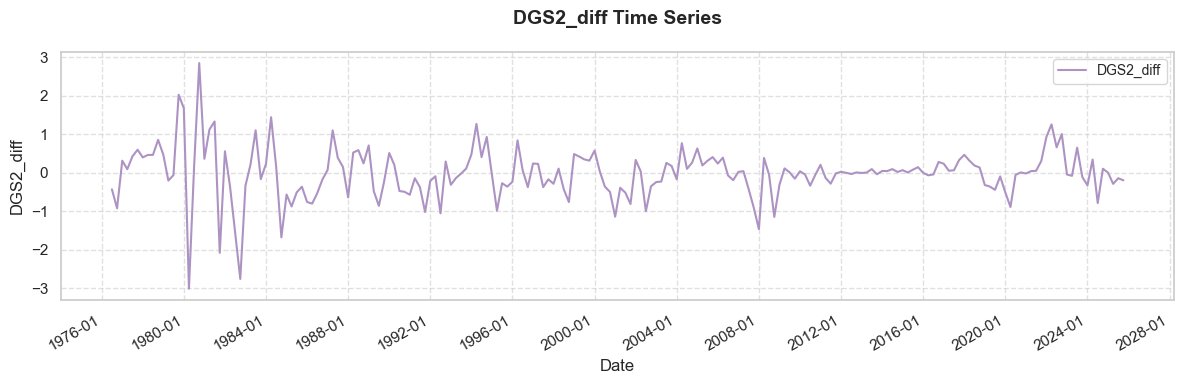

The Time Series is now stationary, after 1 differencing


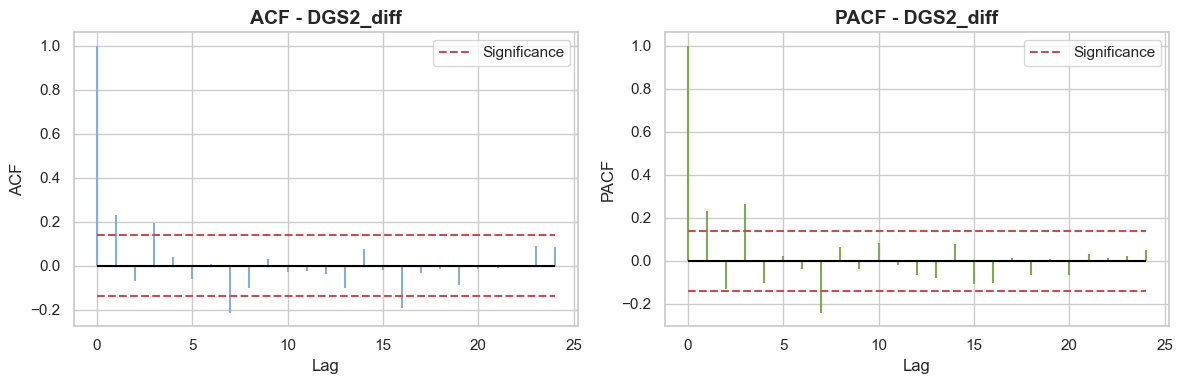

,DGS2,DGS2_diff
date,,
1976-04-01,7.060000,NaN
1976-07-01,6.632500,-0.427500
1976-10-01,5.710820,-0.921680
1977-01-01,6.024762,0.313942
1977-04-01,6.117778,0.093016


In [32]:
final_dgs2 = time_series_analysis_main(df=dgs2_df, date_column_name='observation_date', column_name='DGS2', lags=24, aggregate_method='mean')
final_dgs2.head()

#### 4. **10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant** (T10Y2Y)

The 10-Year Treasury Minus 2-Year Treasury is the difference in yield between the long-term 10-year U.S. Treasury bond and the shorter-term 2-year U.S. Treasury note.

Data availability: 01/06/1976 – 26/09/2025

Data source: https://fred.stlouisfed.org/series/T10Y2Y

In [33]:
t10y2y_df = pd.read_csv('../datasets/T10Y2Y.csv')
t10y2y_df.head()

,observation_date,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


Dataset Information:
                     dtype  missing  n_unique      mean       std   min   max
observation_date   object        0     12935       NaN       NaN   NaN   NaN
T10Y2Y            float64      545       474  0.850043  0.918029 -2.41  2.91
Time Series Dataset:
             T10Y2Y
date              
1976-06-01    0.68
1976-06-02    0.71
1976-06-03    0.70
1976-06-04    0.77
1976-06-07    0.79
T10Y2Y Time Series frequency changed from B to QS-OCT
Aggregated dataset:
               T10Y2Y
date                
1976-04-01  0.801364
1976-07-01  1.099687
1976-10-01  1.467377
1977-01-01  1.332222
1977-04-01  1.248254



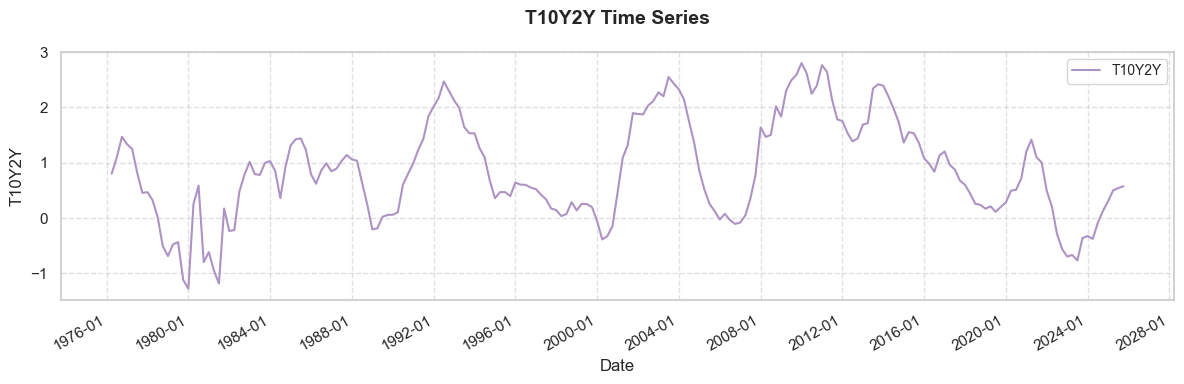

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0  T10Y2Y      -4.083362  0.001032        True


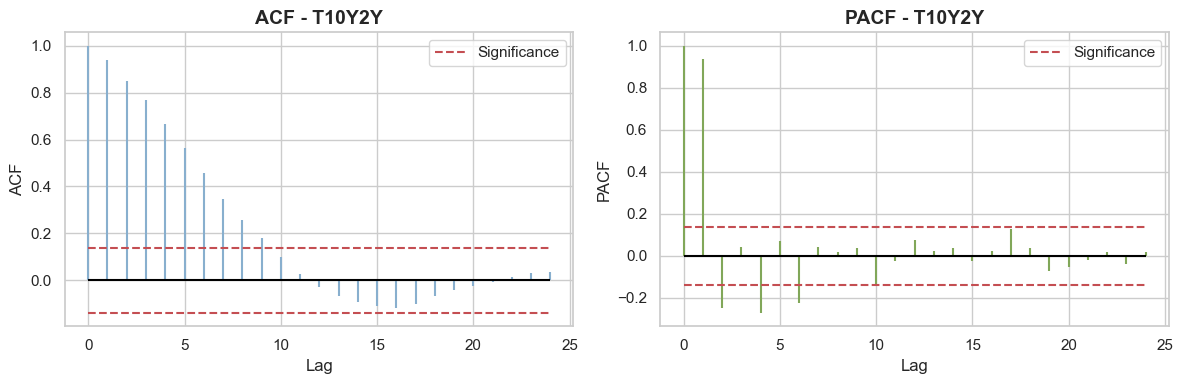

,T10Y2Y
date,
1976-04-01,0.801364
1976-07-01,1.099687
1976-10-01,1.467377
1977-01-01,1.332222
1977-04-01,1.248254


In [34]:
final_t10y2y = time_series_analysis_main(df=t10y2y_df, date_column_name='observation_date', column_name='T10Y2Y', lags=24, aggregate_method='mean')
final_t10y2y.head()

#### 5. **CBOE Volatility Index** (VIXCLS)

The VIX (Volatility Index) is a real-time market index from the Cboe that measures the market's expectation of volatility for the S&P 500 Index over the next 30 days, acting as a gauge of investor fear or confidence.

Data availability: 02/01/1990 – 26/09/2025

Data source: https://fred.stlouisfed.org/series/VIXCLS

In [35]:
vix_df = pd.read_csv('../datasets/VIXCLS.csv')
vix_df.head()

,observation_date,VIXCLS
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [36]:
vix_df = vix_df.rename(columns={'VIXCLS': 'VIX'})

Dataset Information:
                     dtype  missing  n_unique       mean       std   min    max
observation_date   object        0      9389        NaN       NaN   NaN    NaN
VIX               float64      300      2522  19.450858  7.780301  9.14  82.69
Time Series Dataset:
               VIX
date             
1990-01-02  17.24
1990-01-03  18.19
1990-01-04  19.22
1990-01-05  20.11
1990-01-08  20.26
VIX Time Series frequency changed from B to QS-OCT
Aggregated dataset:
                   VIX
date                 
1990-01-01  22.174603
1990-04-01  18.722063
1990-07-01  25.195556
1990-10-01  26.113281
1991-01-01  22.515833



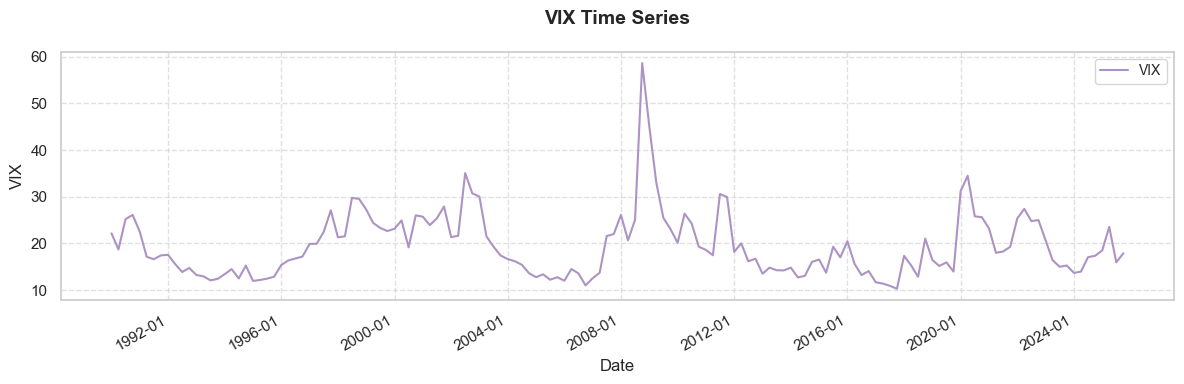

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0     VIX      -4.703398  0.000083        True


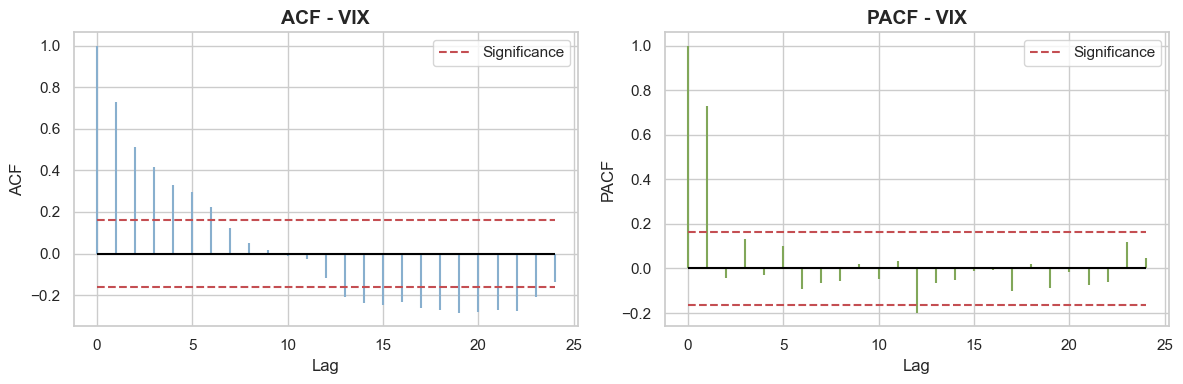

,VIX
date,
1990-01-01,22.174603
1990-04-01,18.722063
1990-07-01,25.195556
1990-10-01,26.113281
1991-01-01,22.515833


In [37]:
final_vix = time_series_analysis_main(df=vix_df, date_column_name='observation_date', column_name='VIX', lags=24, aggregate_method='mean')
final_vix.head()

#### 6. **3-Month Treasury Bill Secondary Market Rate, Discount Basis** (DTB3)

The 3-Month Treasury Bill Secondary Market Rate (Discount Basis) is the annualized yield on U.S. Treasury bills (short-term debt) traded after their initial auction.

Data availability: 04-01-1965 – 26/09/2025

Data source: https://fred.stlouisfed.org/series/DTB3

In [38]:
dtb3_df = pd.read_csv('../datasets/DTB3.csv')
dtb3_df.head()

,observation_date,DTB3
0,1965-01-04,3.81
1,1965-01-05,3.80
2,1965-01-06,3.82
3,1965-01-07,3.80
4,1965-01-08,3.78


Dataset Information:
                     dtype  missing  n_unique      mean       std   min    max
observation_date   object        0     15910       NaN       NaN   NaN    NaN
DTB3              float64      677      1401  4.486041  3.216214 -0.05  17.14
Time Series Dataset:
             DTB3
date            
1965-01-04  3.81
1965-01-05  3.80
1965-01-06  3.82
1965-01-07  3.80
1965-01-08  3.78
DTB3 Time Series frequency changed from B to QS-OCT
Aggregated dataset:
                 DTB3
date                
1965-01-01  3.889672
1965-04-01  3.872381
1965-07-01  3.866875
1965-10-01  4.173934
1966-01-01  4.606190



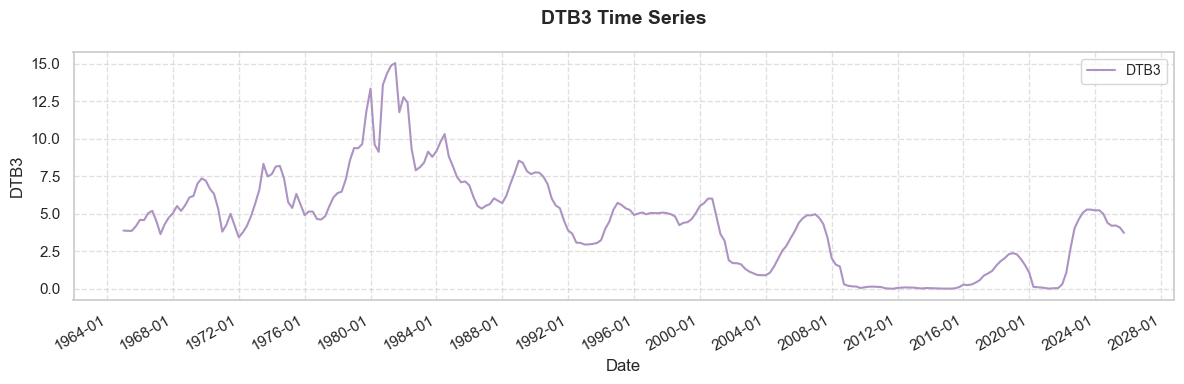

ADF test results:
   Feature  ADF Statistic   p-value  Stationary
0    DTB3      -1.558547  0.504376       False
Differenced Time Series df:
                 DTB3  DTB3_diff
date                           
1965-01-01  3.889672        NaN
1965-04-01  3.872381  -0.017291
1965-07-01  3.866875  -0.005506
1965-10-01  4.173934   0.307059
1966-01-01  4.606190   0.432256
...              ...        ...
2024-10-01  4.400968  -0.597001
2025-01-01  4.208197  -0.192771
2025-04-01  4.229839   0.021642
2025-07-01  4.098750  -0.131089
2025-10-01  3.734068  -0.364682

[244 rows x 2 columns]
ADF test results:
      Feature  ADF Statistic       p-value  Stationary
0  DTB3_diff      -6.079314  1.101965e-07        True


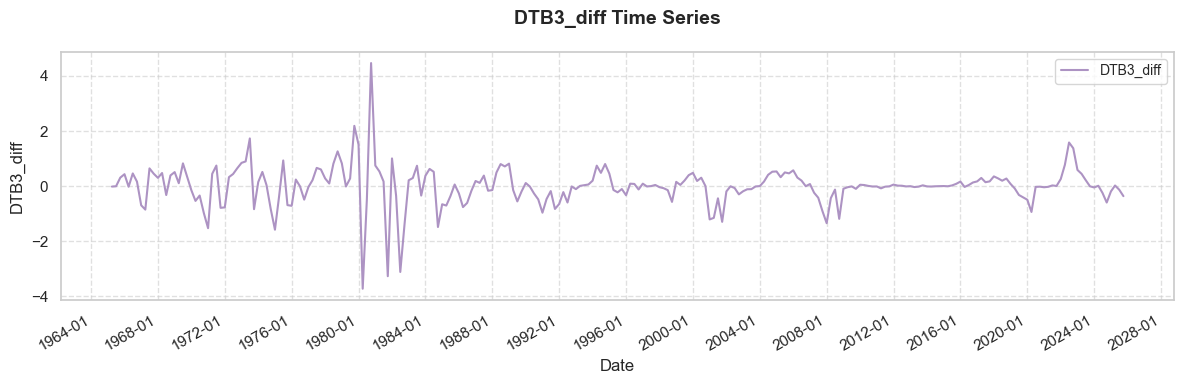

The Time Series is now stationary, after 1 differencing


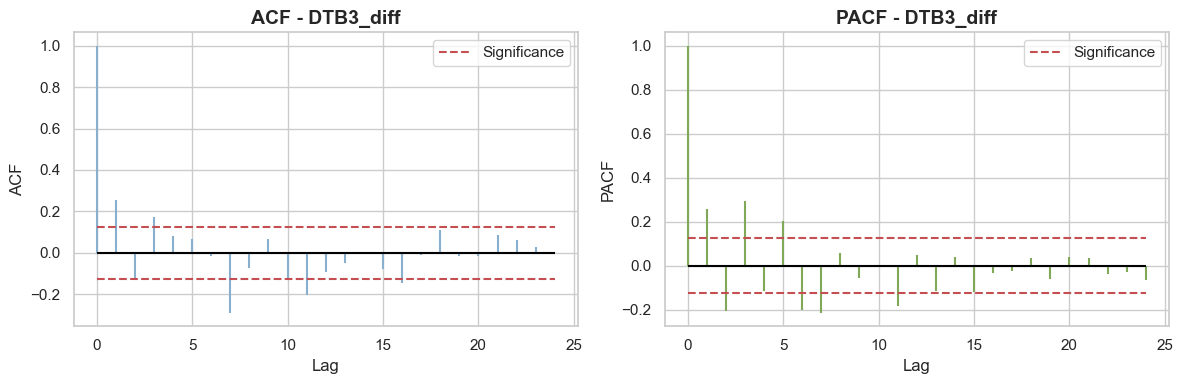

,DTB3,DTB3_diff
date,,
1965-01-01,3.889672,NaN
1965-04-01,3.872381,-0.017291
1965-07-01,3.866875,-0.005506
1965-10-01,4.173934,0.307059
1966-01-01,4.606190,0.432256


In [39]:
final_dtb3 = time_series_analysis_main(df=dtb3_df, date_column_name='observation_date', column_name='DTB3', lags=24, aggregate_method='mean')
final_dtb3.head()

#### 7. **News Sentiment Data** 

News sentiment data refers to quantifiable measures of the collective mood or feeling (positive, negative, neutral) extracted from vast amounts of textual news using Natural Language Processing (NLP) and Machine Learning (ML), serving as a real-time, forward-looking indicator of market expectations, consumer confidence, and economic health.

Data availability: 01/01/1980 – 28/12/2025

Data source: https://www.frbsf.org/research-and-insights/data-and-indicators/daily-news-sentiment-index/

In [40]:
news_sentiment_df = pd.read_excel('../datasets/news_sentiment_data.xlsx', sheet_name='Data', skiprows=1, header=None, names=['observation_date', 'NEWS_SENTIMENT'])
news_sentiment_df.head()

,observation_date,NEWS_SENTIMENT
0,1980-01-01,-0.037927
1,1980-01-02,-0.106654
2,1980-01-03,-0.089502
3,1980-01-05,-0.067226
4,1980-01-06,-0.089110


Dataset Information:
                            dtype  missing  n_unique      mean       std  \
observation_date  datetime64[ns]        0     16780       NaN       NaN   
NEWS_SENTIMENT           float64        0     16780  0.009034  0.181423   

                       min       max  
observation_date       NaN       NaN  
NEWS_SENTIMENT   -0.714208  0.454221  
Time Series Dataset:
             NEWS_SENTIMENT
date                      
1980-01-01       -0.037927
1980-01-02       -0.106654
1980-01-03       -0.089502
1980-01-05       -0.067226
1980-01-06       -0.089110
NEWS_SENTIMENT Time Series frequency changed from None to QS-OCT
Aggregated dataset:
             NEWS_SENTIMENT
date                      
1980-01-01       -0.247040
1980-04-01       -0.585667
1980-07-01       -0.285839
1980-10-01       -0.085084
1981-01-01       -0.008757



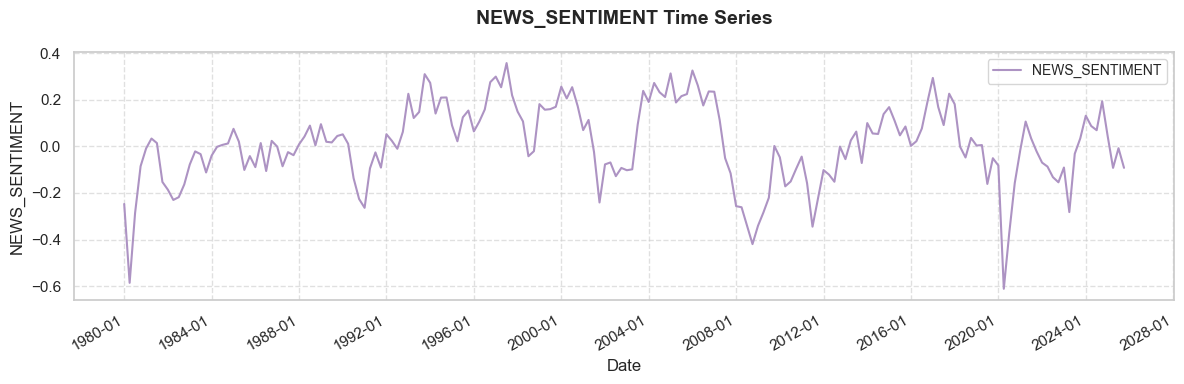

ADF test results:
           Feature  ADF Statistic   p-value  Stationary
0  NEWS_SENTIMENT      -4.308538  0.000429        True


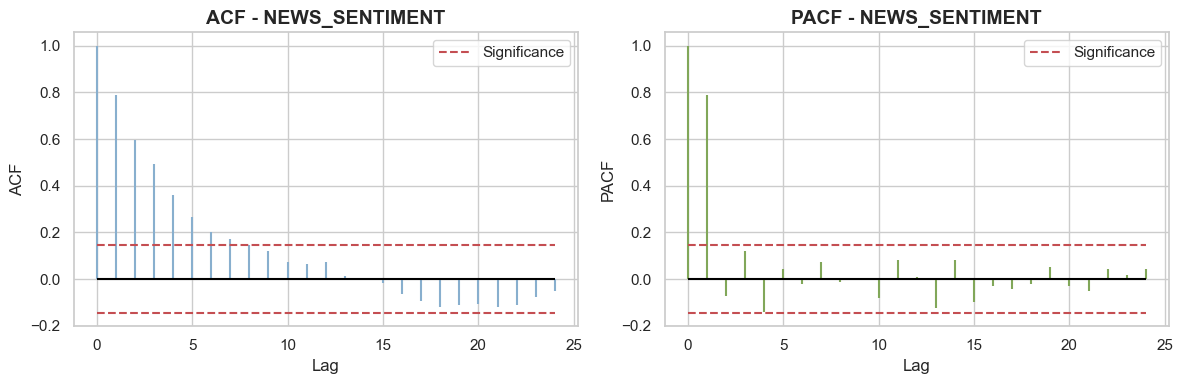

,NEWS_SENTIMENT
date,
1980-01-01,-0.247040
1980-04-01,-0.585667
1980-07-01,-0.285839
1980-10-01,-0.085084
1981-01-01,-0.008757


In [41]:
final_news_sentiment = time_series_analysis_main(df=news_sentiment_df, date_column_name='observation_date', column_name='NEWS_SENTIMENT', lags=24, aggregate_method='mean')
final_news_sentiment.head()

### **Dataset Generation - Merging all time series**

In [42]:
list_all_df= [final_gdp, final_unrate, final_cpi, final_indpro, final_dff, final_dgs10, final_dgs2, final_t10y2y, final_vix, final_dtb3, final_news_sentiment]
list_all_df_names = ['GDP', 'UNRATE', 'CPI', 'INDPRO', 'DFF', 'DGS10', 'DGS2', 'T10Y2Y', 'VIX', 'DTB3', 'NEWS_SENTIMENT']


merged_df = merge_data_with_label(labels_df=labels_df, list_all_df=list_all_df, list_all_df_names=list_all_df_names)
merged_df

,label,GDP,GDP_diff,UNRATE,CPI,CPI_diff,INDPRO,INDPRO_diff,DFF,DFF_diff,DGS10,DGS10_diff,DGS2,DGS2_diff,T10Y2Y,VIX,DTB3,DTB3_diff,NEWS_SENTIMENT
date,,,,,,,,,,,,,,,,,,,
1967-10-01,0,881.439,16.206,3.900000,33.866667,0.366667,35.926333,0.936267,4.172826,0.280978,5.641803,0.394819,NaN,NaN,NaN,NaN,4.748033,0.451049,NaN
1968-01-01,0,909.387,27.948,3.733333,34.200000,0.333333,36.439167,0.512833,4.792637,0.619811,5.610968,-0.030836,NaN,NaN,NaN,NaN,5.048226,0.300193,NaN
1968-04-01,0,934.344,24.957,3.566667,34.533333,0.333333,36.930433,0.491267,5.984286,1.191648,5.746129,0.135161,NaN,NaN,NaN,NaN,5.523226,0.475000,NaN
1968-07-01,0,950.825,16.481,3.533333,35.000000,0.466667,37.216967,0.286533,5.946522,-0.037764,5.458594,-0.287535,NaN,NaN,NaN,NaN,5.198125,-0.325101,NaN
1968-10-01,0,968.030,17.205,3.400000,35.433333,0.433333,37.782167,0.565200,5.918152,-0.028370,5.767742,0.309148,NaN,NaN,NaN,NaN,5.585323,0.387198,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0,29147.044,438.883,4.000000,313.095667,2.121333,100.666800,0.678533,5.330000,0.000000,4.448730,0.292337,4.826190,0.343895,-0.377460,13.980308,5.246190,0.012256,0.087528
2024-07-01,0,29511.664,364.620,4.166667,314.182667,1.087000,100.071667,-0.595133,5.264783,-0.065217,3.954687,-0.494043,4.040625,-0.785565,-0.085938,17.066667,4.997969,-0.248222,0.069566
2024-10-01,0,29825.182,313.518,4.133333,316.538667,2.356000,99.696433,-0.375233,4.647935,-0.616848,4.275484,0.320796,4.145484,0.104859,0.130000,17.363231,4.400968,-0.597001,0.193711


In [43]:
merged_df.to_csv('../datasets/data_merged_NaN.csv', index=True)

In [44]:
merged_df = merged_df.dropna()
print("Start date:", merged_df.index.min())
print("End date:", merged_df.index.max())
merged_df

Start date: 1990-01-01 00:00:00
End date: 2025-04-01 00:00:00


,label,GDP,GDP_diff,UNRATE,CPI,CPI_diff,INDPRO,INDPRO_diff,DFF,DFF_diff,DGS10,DGS10_diff,DGS2,DGS2_diff,T10Y2Y,VIX,DTB3,DTB3_diff,NEWS_SENTIMENT
date,,,,,,,,,,,,,,,,,,,
1990-01-01,1,5872.701,125.464,5.300000,128.033333,2.166667,62.206167,0.458233,8.248000,-0.366457,8.423871,0.516774,8.364839,0.513065,0.059032,22.174603,7.763548,0.112097,0.051820
1990-04-01,1,5960.028,87.327,5.333333,129.300000,1.266667,62.633300,0.427133,8.239341,-0.008659,8.674127,0.250256,8.571111,0.206272,0.103016,18.722063,7.746667,-0.016882,0.011166
1990-07-01,1,6015.116,55.088,5.700000,131.533333,2.233333,62.876067,0.242767,8.160217,-0.079123,8.701270,0.027143,8.098730,-0.472381,0.602540,25.195556,7.477143,-0.269524,-0.136543
1990-10-01,1,6004.733,-10.383,6.133333,133.766667,2.233333,61.902800,-0.973267,7.743370,-0.416848,8.405968,-0.295302,7.606129,-0.492601,0.800161,26.113281,6.994839,-0.482304,-0.225727
1991-01-01,1,6035.178,30.445,6.600000,134.766667,1.000000,60.717967,-1.184833,6.430444,-1.312925,8.022833,-0.383134,7.036000,-0.570129,0.987167,22.515833,6.028667,-0.966172,-0.263631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0,29147.044,438.883,4.000000,313.095667,2.121333,100.666800,0.678533,5.330000,0.000000,4.448730,0.292337,4.826190,0.343895,-0.377460,13.980308,5.246190,0.012256,0.087528
2024-07-01,0,29511.664,364.620,4.166667,314.182667,1.087000,100.071667,-0.595133,5.264783,-0.065217,3.954687,-0.494043,4.040625,-0.785565,-0.085938,17.066667,4.997969,-0.248222,0.069566
2024-10-01,0,29825.182,313.518,4.133333,316.538667,2.356000,99.696433,-0.375233,4.647935,-0.616848,4.275484,0.320796,4.145484,0.104859,0.130000,17.363231,4.400968,-0.597001,0.193711


In [45]:
print(merged_df.columns)

Index(['label', 'GDP', 'GDP_diff', 'UNRATE', 'CPI', 'CPI_diff', 'INDPRO',
       'INDPRO_diff', 'DFF', 'DFF_diff', 'DGS10', 'DGS10_diff', 'DGS2',
       'DGS2_diff', 'T10Y2Y', 'VIX', 'DTB3', 'DTB3_diff', 'NEWS_SENTIMENT'],
      dtype='object')


In [46]:
columns_to_remove = ['GDP', 'CPI', 'INDPRO', 'DFF', 'DGS10', 'DGS2', 'DTB3']
for col in merged_df.columns: 
    if col in columns_to_remove:
        merged_df = merged_df.drop(columns=col)

In [47]:
merged_df.head()

,label,GDP_diff,UNRATE,CPI_diff,INDPRO_diff,DFF_diff,DGS10_diff,DGS2_diff,T10Y2Y,VIX,DTB3_diff,NEWS_SENTIMENT
date,,,,,,,,,,,,
1990-01-01,1,125.464,5.300000,2.166667,0.458233,-0.366457,0.516774,0.513065,0.059032,22.174603,0.112097,0.051820
1990-04-01,1,87.327,5.333333,1.266667,0.427133,-0.008659,0.250256,0.206272,0.103016,18.722063,-0.016882,0.011166
1990-07-01,1,55.088,5.700000,2.233333,0.242767,-0.079123,0.027143,-0.472381,0.602540,25.195556,-0.269524,-0.136543
1990-10-01,1,-10.383,6.133333,2.233333,-0.973267,-0.416848,-0.295302,-0.492601,0.800161,26.113281,-0.482304,-0.225727
1991-01-01,1,30.445,6.600000,1.000000,-1.184833,-1.312925,-0.383134,-0.570129,0.987167,22.515833,-0.966172,-0.263631


In [48]:
merged_df.to_csv('../datasets/data_merged.csv', index=True)